In [1]:
import sys
sys.path.insert(0, '/home/sos/Dialogue_Research/color_in_context/system/dialogue_manager')
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpathes
import torch
import pickle
from adjective_model.Loss_ import loss_
import random
import pickle
# from plot import plot_change
# from plot import get_compara_direction

In [9]:
# data wrangling
cdict = {}
dirc = "./xkcd_colordata/"
for cfile in os.listdir(dirc):
    if cfile.endswith(".train") or cfile.endswith(".dev"):
        cname = cfile[:cfile.find(".")]
        with open(dirc+cfile,"rb") as f:
            all_samples = np.array(pickle.load(f)) / 255   # normalized to [0,1]
#             print(cname, '\n',  all_samples)
            cdict[cname] = torch.FloatTensor(all_samples.mean(axis=0))
#             break

label2words = {}
with open("words_to_labels.txt",encoding="utf-8") as f:
    for line in f:
        words, label = line.strip().split(',')
        label2words[label] = words

In [10]:
cdict['blue']
len(cdict)
# 'duller' in embeddings.keys()
cdict

{'aubergine': tensor([0.3971, 0.1646, 0.3615]),
 'red': tensor([0.8002, 0.1395, 0.1649]),
 'darkblue': tensor([0.1259, 0.1710, 0.4931]),
 'coolgreen': tensor([0.2303, 0.7461, 0.4142]),
 'turquoise': tensor([0.2030, 0.7592, 0.6922]),
 'brightturquoise': tensor([0.1669, 0.8895, 0.8081]),
 'cerise': tensor([0.8115, 0.1788, 0.4739]),
 'darkmaroon': tensor([0.3533, 0.0994, 0.1656]),
 'chocolate': tensor([0.3837, 0.2189, 0.1347]),
 'camel': tensor([0.7657, 0.6232, 0.3108]),
 'bluishpurple': tensor([0.3871, 0.2230, 0.7673]),
 'pea': tensor([0.5943, 0.7593, 0.2590]),
 'ochre': tensor([0.7344, 0.5304, 0.1722]),
 'lightmustard': tensor([0.8602, 0.8134, 0.3396]),
 'purplish': tensor([0.5718, 0.2689, 0.6461]),
 'pinkish': tensor([0.8562, 0.4005, 0.5958]),
 'salmonpink': tensor([0.9119, 0.4695, 0.4727]),
 'ultramarine': tensor([0.1819, 0.2537, 0.7346]),
 'plum': tensor([0.4541, 0.1696, 0.3890]),
 'darkhotpink': tensor([0.8295, 0.1134, 0.5043]),
 'banana': tensor([0.9005, 0.8680, 0.3171]),
 'forestg

In [11]:
to_compara = dict(line.strip().split(":") for line in open("comparatives.txt", encoding="utf-8"))
to_more_quanti = dict(line.strip().split(":") for line in open("quantifiers.txt", encoding="utf-8"))

triples = []
for label in cdict:
    words = label2words[label].split()
    if len(words) > 1:
        quantifier, base = words[0], "".join(words[1:])
        if base in cdict:
            if quantifier in to_compara:        # uni-gram('lighter',)
                triples.append((label, (to_compara[quantifier],), base))
            elif quantifier in to_more_quanti:  # bigram('more','bluish')
                triples.append((label, ("more", to_more_quanti[quantifier]), base))
triples[:5]                

[('darkblue', ('darker',), 'blue'),
 ('brightturquoise', ('brighter',), 'turquoise'),
 ('darkmaroon', ('darker',), 'maroon'),
 ('lightmustard', ('lighter',), 'mustard'),
 ('darkhotpink', ('darker',), 'hotpink')]

In [14]:
with open("embeddings.pickle","rb") as f:
    embeddings = pickle.load(f)
'dark' in embeddings
# net = loss_(triples, cdict, embeddings)  

True

In [6]:
# pickle.dump(net, \
#     open('/home/sos/Dialogue_Research/color_in_context/system/dialogue_manager/dataset/adj_network.pkl', 'wb'))
# pickle.dump(embeddings, \
#     open('/home/sos/Dialogue_Research/color_in_context/system/dialogue_manager/adj_embed.pkl', 'wb'))
# pickle.dump(cdict, \
#     open('/home/sos/Dialogue_Research/color_in_context/system/dialogue_manager/color_dict.pkl', 'wb'))
# net = pickle.load(open('/home/sos/Dialogue_Research/color_in_context/system/dialogue_manager/adj_network.pkl', 'rb'))
# embeddings = pickle.load(open('/home/sos/Dialogue_Research/color_in_context/system/dialogue_manager/adj_embed.pkl', 'rb'))
# cdict = pickle.load(open('/home/sos/Dialogue_Research/color_in_context/system/dialogue_manager/color_dict.pkl', 'rb'))

/usr/local/lib/python3.6/dist-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [48]:
def get_compara_direction(cdict, embeddings, net, compara, source_str):
    comp_words = compara.split()
    if len(comp_words) == 1:
        emb1, emb2 = torch.zeros(300,), torch.from_numpy(embeddings[comp_words[0]])
    else:
        emb1, emb2 = torch.from_numpy(embeddings[comp_words[0]]), torch.from_numpy(embeddings[comp_words[1]])
    emb1, emb2 = torch.FloatTensor(emb1), torch.FloatTensor(emb2)
    source = None
    if type(source_str) == str:
        source = cdict[source_str.replace(' ', '')]
    else:
        source = torch.tensor(source_str, dtype=torch.float)
        
    wg = net(emb1, emb2, source)
    return wg.detach().numpy()

In [69]:
def plot_change(cdict, embeddings, net, compara, source_str, strength=1, save_path=None):
    print(source_str)
    ax = plt.gca()
    source = None
    if type(source_str) == str:
        source = cdict[source_str.replace(' ', '')]
    else:
        source = torch.tensor(source_str, dtype=torch.float)
#     source = source_str
    direction = get_compara_direction(cdict, embeddings, net, compara, source_str)
    print(direction)
    ax = plt.gca()
    N = 100
    width, height = 1, 1
    for x in np.linspace(0, width, N):
#         print(x, width, N)
        ax.add_patch(mpathes.Rectangle([x,0],width/N,height,color=np.clip(source+direction*x*strength,0,1)))
    plt.axis('off')
    if save_path:
        plt.savefig(save_path)
    plt.show()

In [8]:
# grassy | dull | darkest | most | true | brighter | more | less | hint | saturated |
# super | lakers | darker | little | dark | lightest | bright | normal | closest | almost | brightest |
# lighter | rich | richer | duller | drabbest | vibrant | second | slightly | regular | based | in between |
# different | least | paler | palest | light
class AdjModel():
    def __init__(self):
        self.net = pickle.load(open('/home/sos/Dialogue_Research/color_in_context/' + \
                                'system/dialogue_manager/adj_network.pkl', 'rb'))
        self.embeddings = pickle.load(open('/home/sos/Dialogue_Research/color_in_context/' + \
                                'system/dialogue_manager/adj_embed.pkl', 'rb'))
        self.cdict = pickle.load(open('/home/sos/Dialogue_Research/color_in_context/system/' + \
                                'dialogue_manager/color_dict.pkl', 'rb'))
        
    def get_compara_direction(self, compara, source_str):
        comp_words = compara.split()
        if len(comp_words) == 1:
            emb1, emb2 = torch.zeros(300,), torch.from_numpy(self.embeddings[comp_words[0]])
        else:
            emb1, emb2 = torch.from_numpy(embeddings[comp_words[0]]), torch.from_numpy(self.embeddings[comp_words[1]])
        emb1, emb2 = torch.FloatTensor(emb1), torch.FloatTensor(emb2)
        source = None
        if type(source_str) == str:
            source = self.cdict[source_str.replace(' ', '')]
        else:
            source = torch.tensor(source_str, dtype=torch.float)

        wg = self.net(emb1, emb2, source)
        return wg.detach().numpy()
    
    def plot_change(self, compara, source_str, strength=1, save_path=None):
#         print(source_str)
        ax = plt.gca()
        source = None
        if type(source_str) == str:
            source = self.cdict[source_str.replace(' ', '')]
        else:
            source = torch.tensor(source_str, dtype=torch.float)
    #     source = source_str
        direction = self.get_compara_direction(compara, source_str)
#         print(direction)
        ax = plt.gca()
        N = 100
        width, height = 1, 1
        for x in np.linspace(0, width, N):
    #         print(x, width, N)
            ax.add_patch(mpathes.Rectangle([x,0],width/N,height,color=np.clip(source+direction*x*strength,0,1)))
        plt.axis('off')
        if save_path:
            plt.savefig(save_path)
        plt.show()
adj_model = AdjModel()
len(adj_model.cdict)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sos/Dialogue_Research/color_in_context/system/dialogue_manager/adj_network.pkl'

In [7]:
'darkest' in adj_model.embeddings
# adj_model.plot_change("darker", "dark red", strength=2)
# plot_change(cdict, embeddings, net, "darker yellowish", np.array([random.random() for i in range(3)]), strength=2)
# direction = adj_model.get_compara_direction('darker', 'red')
# sum(direction)
# np.linalg.norm(direction)
# sum(map(lambda x : x * x, direction/np.linalg.norm(direction)))
# direction
# direction
# print(cdict)
# x = np.array([0.11322622, 0.49956796, 0.55025133])
# y = np.array([ 0.02411209, 0.11326184, -0.1392503])
# color=np.clip(x+y*100*1,0,1)
# color
# print((x + y) * 255)
# [-0.04969486  0.12912533 -0.19653028]

NameError: name 'adj_model' is not defined

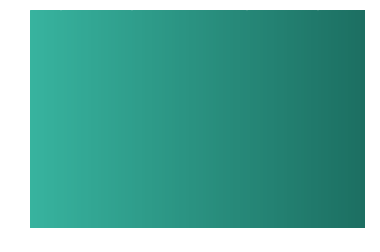

In [10]:
plot_change(cdict, embeddings, net, "darker", "teal",2)

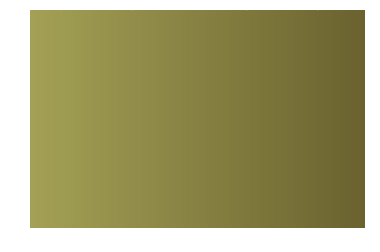

In [11]:
plot_change(cdict, embeddings, net,"darker", "khaki",2)

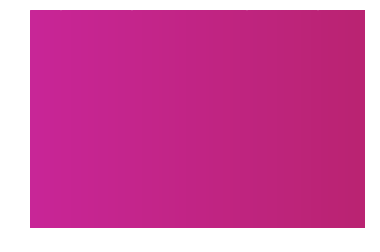

In [12]:
plot_change(cdict, embeddings, net, "electric", "magenta",1 )

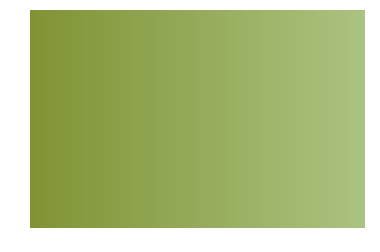

In [13]:
plot_change(cdict, embeddings, net, "lighter", "olive",2 )

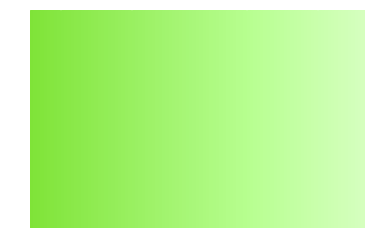

In [14]:
plot_change(cdict, embeddings, net, "lighter", "lime",4 )

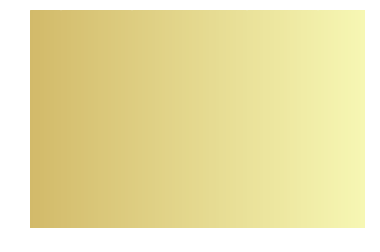

In [35]:
plot_change(cdict, embeddings, net,"lighter", "sand",3 )

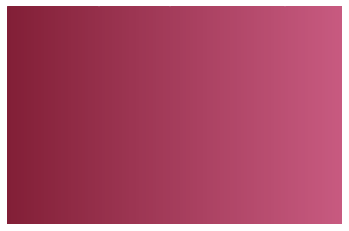

In [92]:
plot_change(cdict, embeddings, net, "lighter", "maroon",2 )

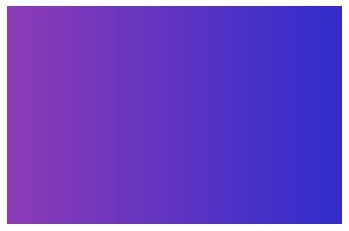

In [75]:
plot_change(cdict, embeddings, net, "bluer", "violet",3 )

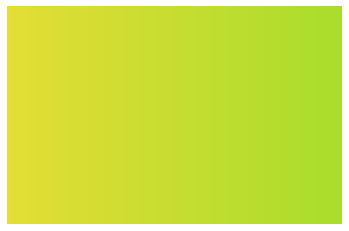

In [91]:
plot_change(cdict, embeddings, net, "more greenish","yellow",2 )

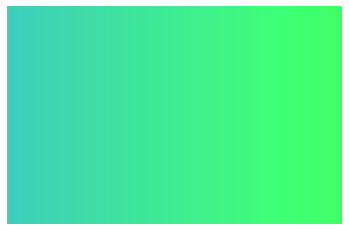

In [77]:
plot_change(cdict, embeddings, net, "more greenish","aqua",5 )

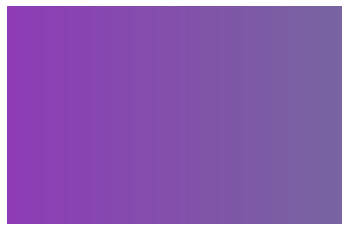

In [85]:
plot_change(cdict, embeddings, net, "more blueish","violet",4 )

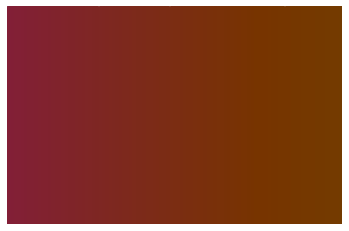

In [79]:
plot_change(cdict, embeddings, net, "more yellowish","maroon",4 )

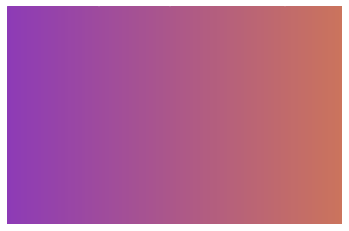

In [96]:
plot_change(cdict, embeddings, net, "more yellowish","violet",4 )